In [1]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt

In [2]:
sqrtns = [128, 160, 192, 224, 256]
block_sizes = [512, 256, 128, 64]
nts = np.arange(36, 0, -3)

data_size = (len(sqrtns), len(block_sizes), len(nts), 10)
ompfor_data_time = np.ones(data_size)*10000
ompfor_error_time = np.ones(data_size)*10000
ompfor_mem_footprint = np.ones(data_size)*10000
batch_data_time = np.ones(data_size)*10000
batch_error_time = np.ones(data_size)*10000
batch_mem_footprint = np.ones(data_size)*10000
with open("result.txt", "r") as fd:
    all_lines = fd.readlines()
    for i in reversed(range(len(all_lines))):
        if all_lines[i][0] == '#':
            del all_lines[i]
    total_tests = len(all_lines)/18
    #print len(all_lines)/float(18)
    i2 = 0
    for i in range(18, len(all_lines)+1, 18):
        run_cmd = all_lines[i-18]
        ompfor_time = all_lines[i-16]
        ompfor_error = all_lines[i-15]
        ompfor_mem = all_lines[i-6]
        batch_time = all_lines[i-13]
        batch_error = all_lines[i-12]
        batch_mem = all_lines[i-3]
        #print run_cmd, ompfor, batch,
        sp = run_cmd.split()
        sqrtn, bs, nt = map(int, [sp[j] for j in [1, 2, 8]])
        #print rb, cb, bs, mr, nt, rb*cb
        sqrtn_index = sqrtns.index(sqrtn)
        bs_index = block_sizes.index(bs)
        nt_index = nt/3-1
        #print sqrtn_index, bs_index, nt_index, i2
        ompfor_data_time[sqrtn_index, bs_index, nt_index, i2] = float(ompfor_time.split()[-2])
        ompfor_error_time[sqrtn_index, bs_index, nt_index, i2] = float(ompfor_error.split()[-2])
        ompfor_mem_footprint[sqrtn_index, bs_index, nt_index, i2] = float(ompfor_mem.split()[-4])
        batch_data_time[sqrtn_index, bs_index, nt_index, i2] = float(batch_time.split()[-2])
        batch_error_time[sqrtn_index, bs_index, nt_index, i2] = float(batch_error.split()[-2])
        batch_mem_footprint[sqrtn_index, bs_index, nt_index, i2] = float(batch_mem.split()[-4])
        if i2 == 9:
            i2 = 0
        else:
            i2 += 1

def prepare_data(data):
    tmp_array = np.ndarray(data_size[3])
    mean = np.ndarray((data_size[0], data_size[1], data_size[2]))
    sigma = np.ndarray((data_size[0], data_size[1], data_size[2]))
    for i in range(data_size[0]):
        for j in range(data_size[1]):
            for k in range(data_size[2]):
                for l in range(data_size[3]):
                    tmp_array[l] = data[i, j, 0].mean()/data[i, j, k, l]
                mean[i, j, k] = tmp_array.mean()
                sigma[i, j, k] = ((tmp_array-mean[i, j, k])**2).mean()**0.5
    return mean, sigma

def prepare_data_cmp(data, data2):
    tmp_array = np.ndarray(data_size[3])
    mean = np.ndarray((data_size[0], data_size[1], data_size[2]))
    sigma = np.ndarray((data_size[0], data_size[1], data_size[2]))
    for i in range(data_size[0]):
        for j in range(data_size[1]):
            for k in range(data_size[2]):
                for l in range(data_size[3]):
                    tmp_array[l] = data2[i, j, k].mean()/data[i, j, k, l]
                mean[i, j, k] = tmp_array.mean()
                sigma[i, j, k] = ((tmp_array-mean[i, j, k])**2).mean()**0.5
    return mean, sigma

size = np.array(sqrtns)**2
draw_bs = block_sizes
draw_nthreads = [0, 1, 3, 5, 7, 9, 11]

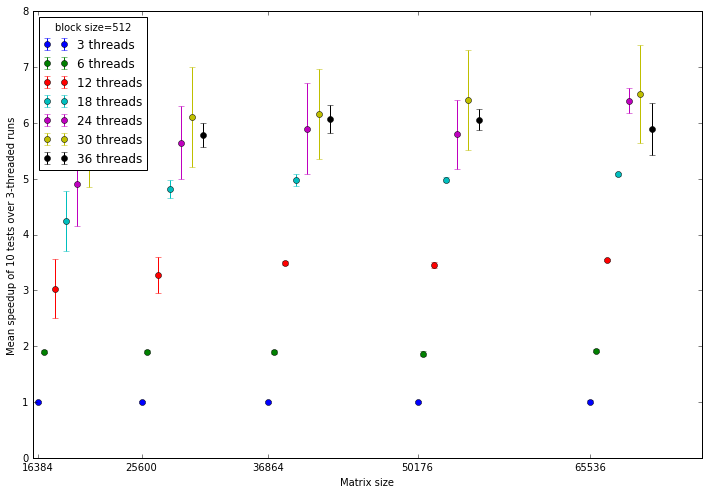

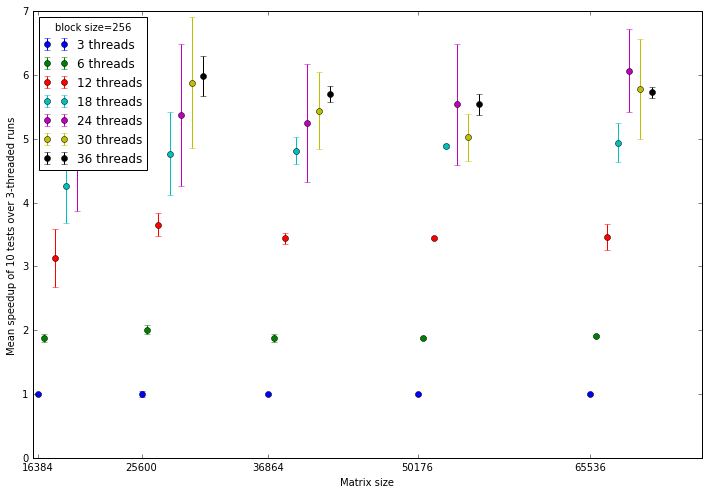

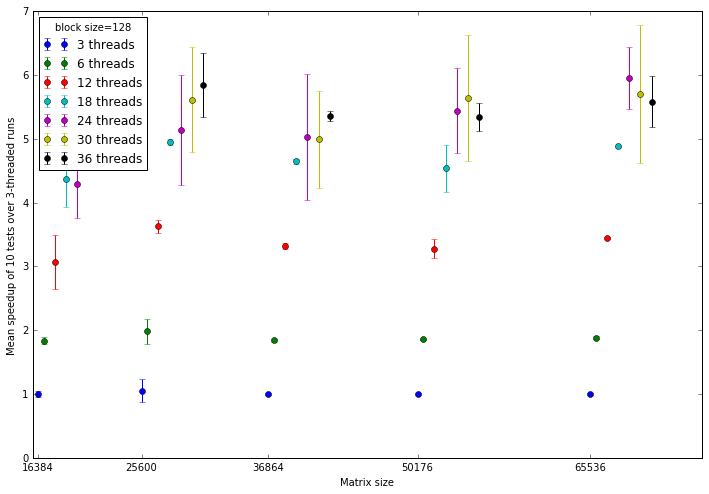

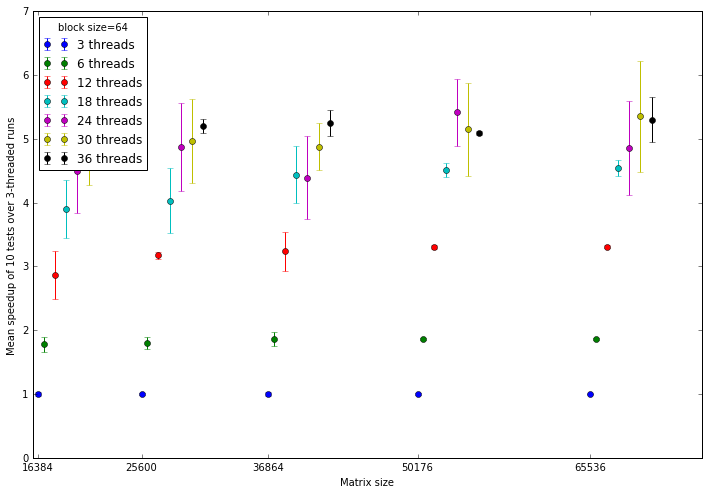

In [3]:
mean, sigma = prepare_data(batch_data_time)

for bs in draw_bs:
    fig, ax = plt.subplots(figsize=(12,8))
    bs_index = block_sizes.index(bs)
    for i in draw_nthreads:
        ax.errorbar(size+500*i, mean[:, bs_index, i], sigma[:, bs_index, i], fmt = "o",
                    label="{} threads".format(3*i+3))
    ax.set_xticks(size)
    ax.set_xlim(size[0]-500, size[-1]+10000)
    ax.set_xticklabels(size)
    ax.set_xlabel("Matrix size")
    ax.set_ylabel("Mean speedup of 10 tests over 3-threaded runs")
    #ax.set_yticklabels(np.arange())
    ax.legend(title="block size={}".format(bs), loc=2)
    plt.savefig("batched_speedup_bs{}.pdf".format(bs))
    plt.show()
    plt.close()

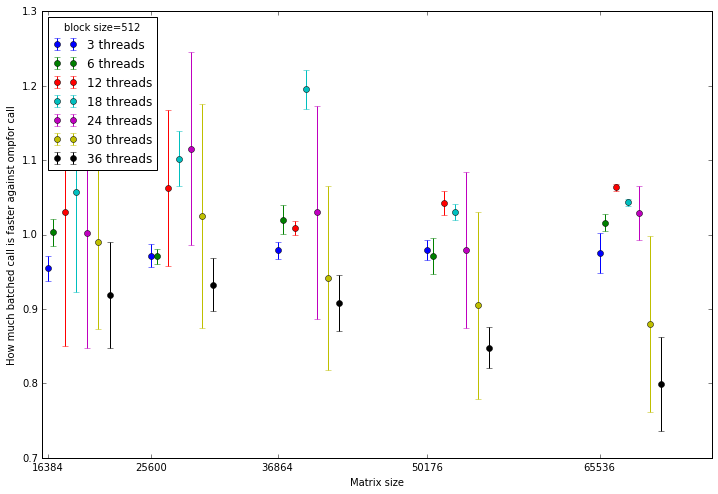

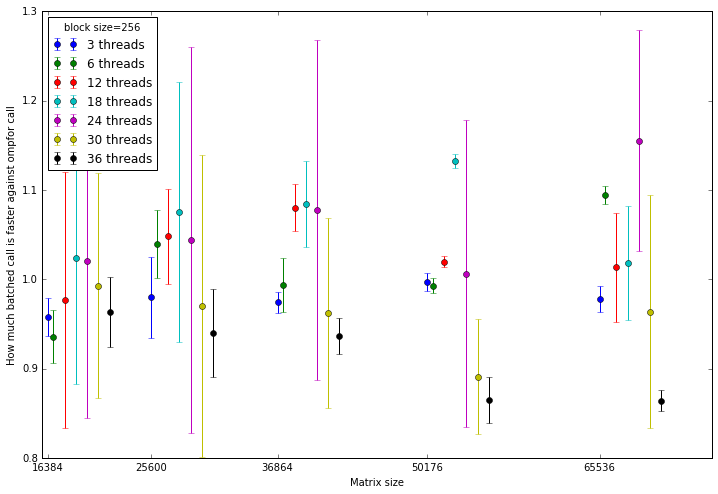

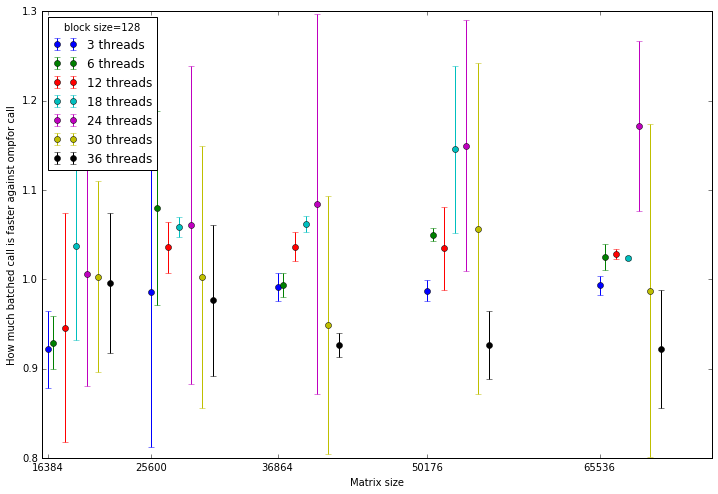

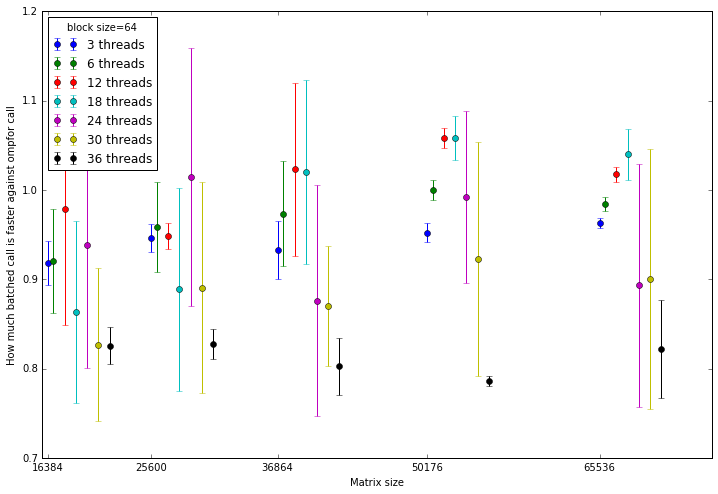

In [4]:
mean, sigma = prepare_data_cmp(batch_data_time, ompfor_data_time)

for bs in draw_bs:
    fig, ax = plt.subplots(figsize=(12,8))
    bs_index = block_sizes.index(bs)
    for i in draw_nthreads:
        ax.errorbar(size+500*i, mean[:, bs_index, i], sigma[:, bs_index, i], fmt = "o",
                    label="{} threads".format(3*i+3))
    ax.set_xticks(size)
    ax.set_xlim(size[0]-500, size[-1]+10000)
    ax.set_xticklabels(size)
    ax.set_xlabel("Matrix size")
    ax.set_ylabel("How much batched call is faster against ompfor call")
    #ax.set_yticklabels(np.arange())
    ax.legend(title="block size={}".format(bs), loc=2)
    plt.savefig("batched_vs_ompfor_bs{}.pdf".format(bs))
    plt.show()
    plt.close()

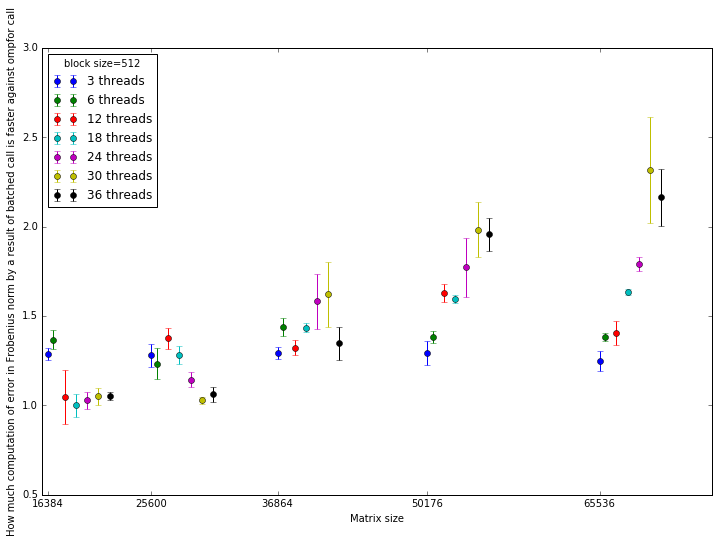

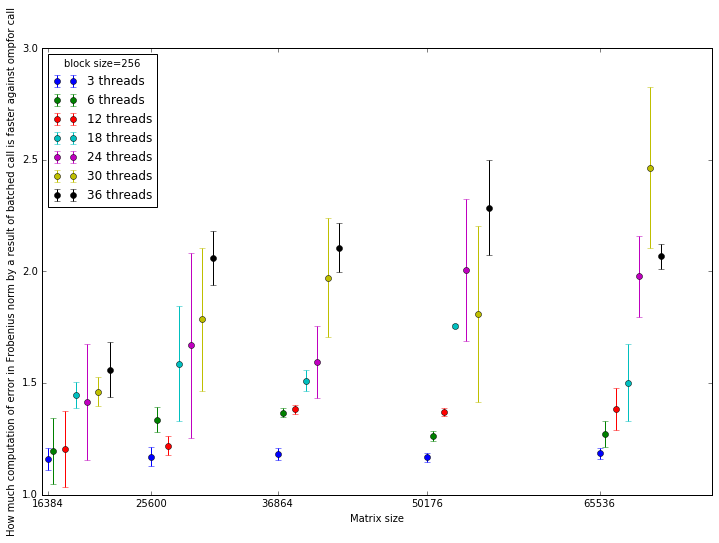

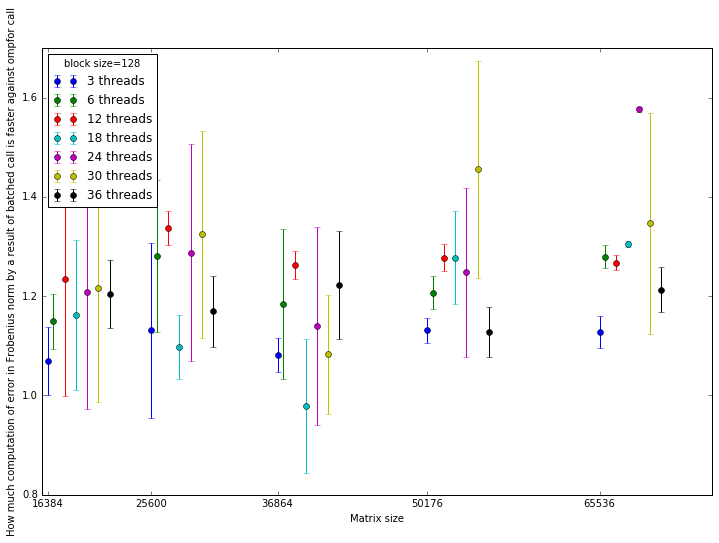

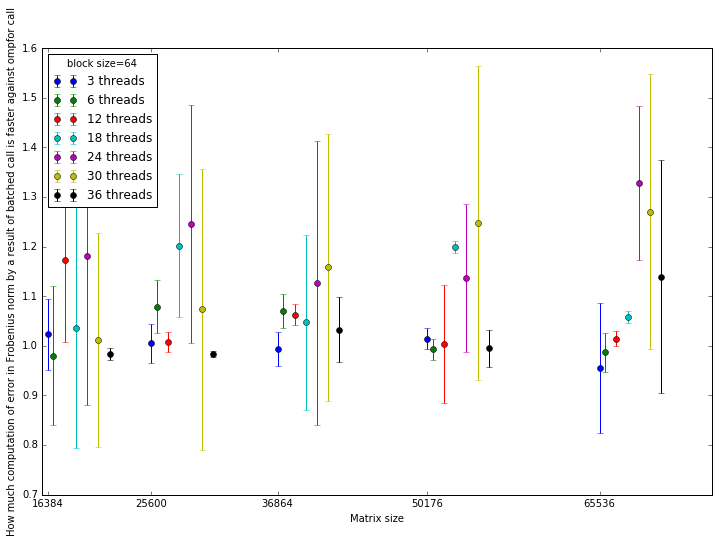

In [5]:
mean, sigma = prepare_data_cmp(batch_error_time, ompfor_error_time)

for bs in draw_bs:
    fig, ax = plt.subplots(figsize=(12,8))
    bs_index = block_sizes.index(bs)
    for i in draw_nthreads:
        ax.errorbar(size+500*i, mean[:, bs_index, i], sigma[:, bs_index, i], fmt = "o",
                    label="{} threads".format(3*i+3))
    ax.set_xticks(size)
    ax.set_xlim(size[0]-500, size[-1]+10000)
    ax.set_xticklabels(size)
    ax.set_xlabel("Matrix size")
    ax.set_ylabel("How much computation of error in Frobenius norm by a result of "
                  "batched call is faster against ompfor call")
    #ax.set_yticklabels(np.arange())
    ax.legend(title="block size={}".format(bs), loc=2)
    plt.savefig("gemms_for_error_measurements_bs{}.pdf".format(bs))
    plt.show()
    plt.close()

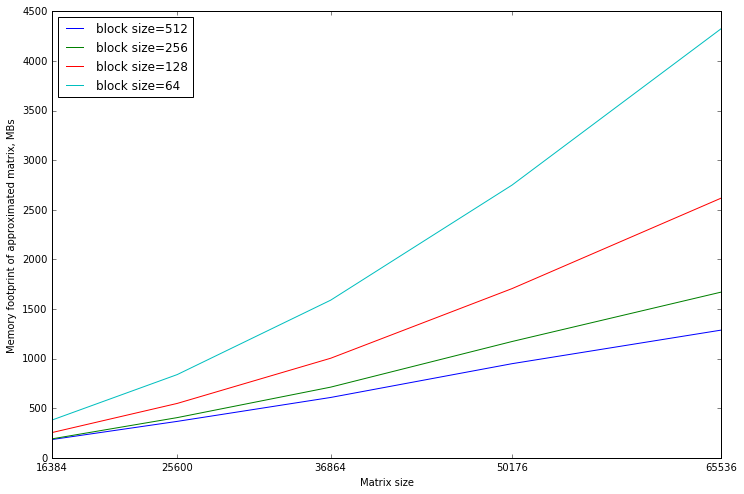

In [6]:
mem_footprint = ompfor_mem_footprint[:, :, 0, 0]

fig, ax = plt.subplots(figsize=(12,8))
bs_index = block_sizes.index(bs)
for bs in draw_bs:
    bs_index = block_sizes.index(bs)
    ax.plot(size, mem_footprint[:, bs_index], label="block size={}".format(bs))
ax.set_xticks(size)
ax.set_xlim(size[0], size[-1])
ax.set_xticklabels(size)
ax.set_xlabel("Matrix size")
ax.set_ylabel("Memory footprint of approximated matrix, MBs")
#ax.set_yticklabels(np.arange())
ax.legend(loc=2)
plt.savefig("memory_footprint.pdf")
plt.show()
plt.close()

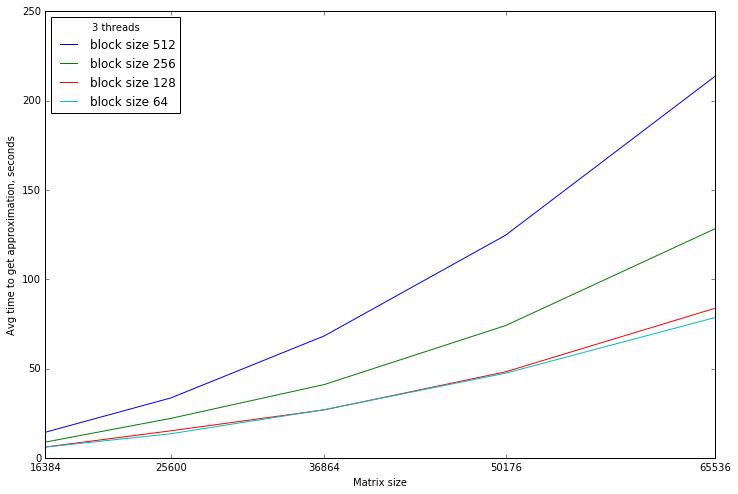

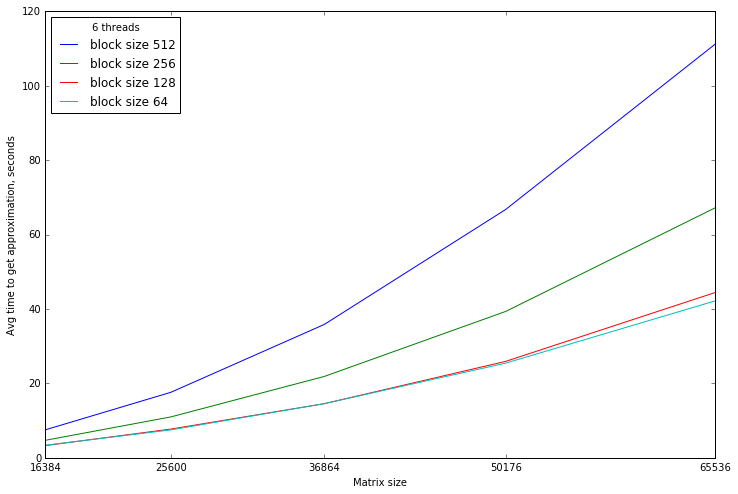

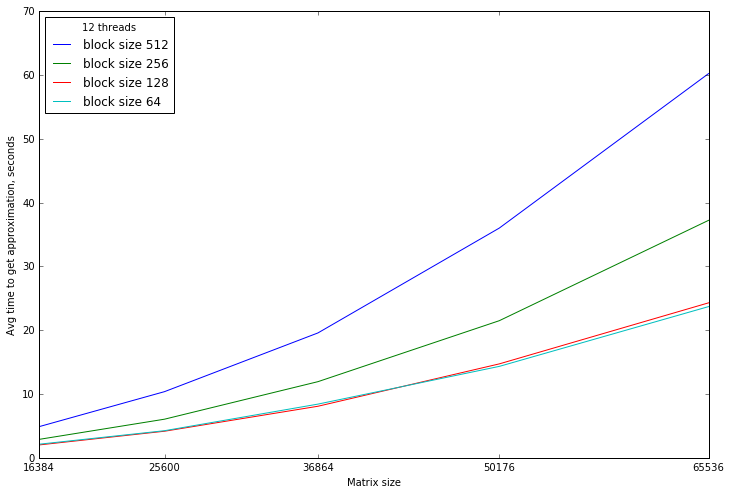

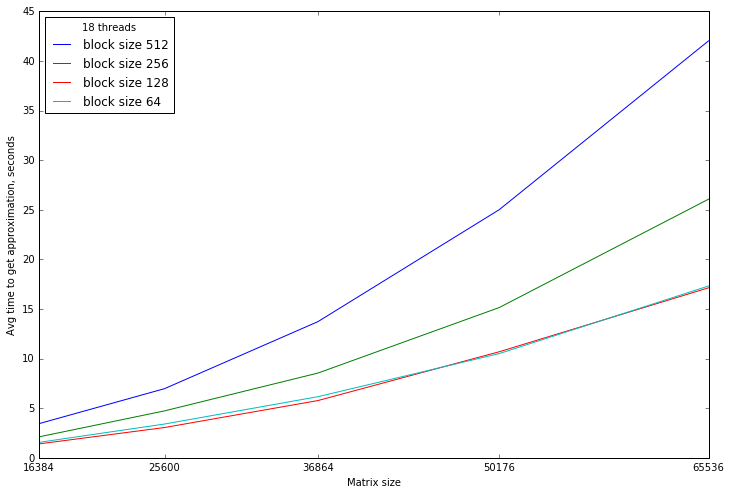

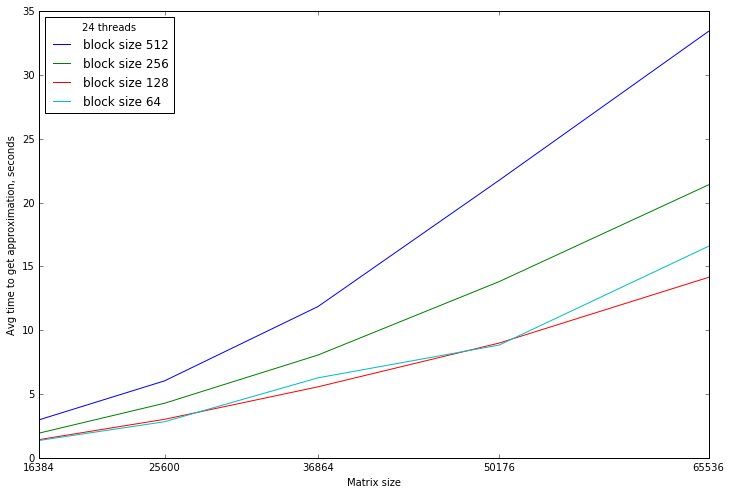

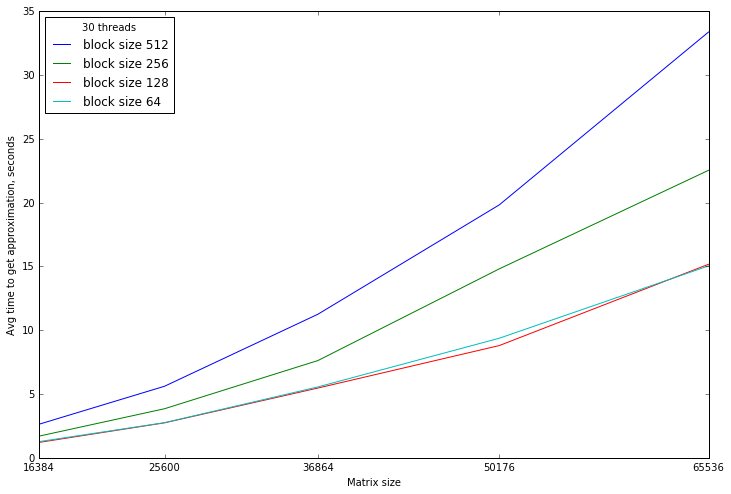

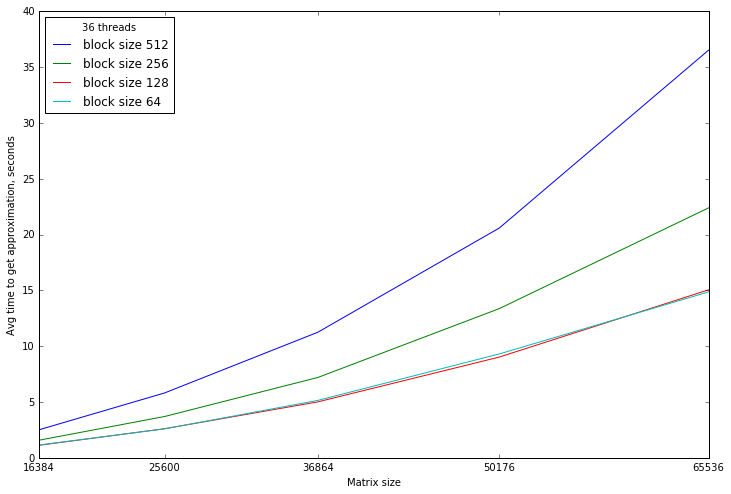

In [7]:
mean = batch_data_time.mean(axis=-1)

for nt_index in draw_nthreads:
    fig, ax = plt.subplots(figsize=(12,8))
    nt = nt_index*3+3
    for bs in draw_bs:
        bs_index = block_sizes.index(bs)
        ax.plot(size, mean[:, bs_index, nt_index], label="block size {}".format(bs))
    ax.set_xticks(size)
    ax.set_xlim(size[0], size[-1])
    ax.set_xticklabels(size)
    ax.set_xlabel("Matrix size")
    ax.set_ylabel("Avg time to get approximation, seconds")
    ax.legend(title="{} threads".format(nt), loc=2)
    #ax.set_yticklabels(np.arange())
    plt.savefig("time_to_approximate_nthreads{}.pdf".format(nt))
    plt.show()
    plt.close()